In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00


我在看一下你那邊是做啥
隨機森林 類神經 決策樹

In [ ]:
#完整  XGBoost 使用lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve


#五種
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

df = pd.read_excel('dataset.xlsx')
df_copy = df.copy()
target_variable = 'market_segment'

##########################################################
#資料處理
#預處理1: 移除沒有目標變數的項目
df_copy.dropna(subset=[target_variable], inplace=True)
#預處理2: 用中位數補零
for col in df_copy.columns:
    if col != target_variable and pd.api.types.is_numeric_dtype(df_copy[col]):
        df_copy[col].fillna(df_copy[col].median(), inplace=True)
#預處理3: 1th-99th
for col in df_copy.select_dtypes(include=np.number):
    if col != target_variable:
        p1 = np.percentile(df_copy[col], 1)
        p99 = np.percentile(df_copy[col], 99)
        df_copy[col] = np.clip(df_copy[col], p1, p99)
#預處理4: 分訓練集&測試集7:3
train_df, test_df = train_test_split(df_copy, test_size=0.3, random_state=42)
#預處理5: 增加一個特徵：「像素密度」= ( display_v * display_h ) / (panel_height * panel_width)，再以Lasso回歸選擇特徵並分別以決策樹、隨機森林及類神經網路建模。決策樹的模型設定上，使用GridSearchCV，GridSearchCV param_grid = { 'n_estimators': [100, 200, 500], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', None] }用決策數建模後，分別對test_df進行預測，並計算評估指標(精確度、F1-Score)
for df in [train_df, test_df]:
    if {'display_v', 'display_h', 'panel_height', 'panel_width'}.issubset(df.columns):
        df['pixel_density'] = (df['display_v'] * df['display_h']) / (df['panel_height'] * df['panel_width']).replace(0,1e-6)
#預處理6: GridSearchCV，分離特徵和目標變數：將 market_segment 作為目標變數，其餘為特徵。
X_train = train_df.drop('market_segment', axis=1)
y_train = train_df['market_segment']
X_test = test_df.drop('market_segment', axis=1)
y_test = test_df['market_segment']
#預處理7(貌似無必要): 將目標變數 y_train 和 y_test（即 market_segment）從文字或類別型數據轉換成數字標籤，以便機器學習模型可以處理。
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.transform(y_test)


####################################################
lasso = Lasso(alpha=10)  # You might need to tune alpha
lasso.fit(X_train, y_train)
selected_features = X_train.columns[lasso.coef_ != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print("selected_features",selected_features)


###################################################

# 3. 使用 GridSearchCV 調參並訓練 XGBoost 模型

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

'''
初始化了一個 XGBoost 分類器，即 XGBClassifier，並設置了一些特定參數
1.random_state=42 ->固定隨機種子以保證結果的可重現性。在每次執行中，隨機過程（如樣本選擇）會產生相同的結果。
2.use_label_encoder=False -> 從 XGBoost 1.3 版開始，為了與 Scikit-learn 接軌，XGBoost 支援直接處理數字標籤。設置為 False，表示不再使用內建的 LabelEncoder，而是依賴外部的編碼（如 Scikit-learn 的 LabelEncoder）。
3.eval_metric='logloss' ->設定評估指標為對數損失（logarithmic loss）。適用於多分類和二分類問題。該指標衡量預測的機率分佈與真實分佈的接近程度。
'''
xgb = XGBClassifier(random_state=42)

#使用GridSearchCV: 1. 自動調參：不需要手動嘗試每個參數組合、2.交叉驗證：使用交叉驗證確保模型性能的穩定性。、3.最佳模型選擇：返回最佳參數下的模型。
grid_search = GridSearchCV(estimator=xgb,param_grid=param_grid,  cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
#執行GridSearchCV
grid_search.fit(X_train_selected, y_train)

# 獲取grid_search最佳模型
best_xgb_model = grid_search.best_estimator_

# 進行測試集評估
y_pred_test = best_xgb_model.predict(X_test_selected)
y_pred_prob = best_xgb_model.predict_proba(X_test_selected)  # 用於 AUC 計算

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')  # ROC AUC
pr_auc = average_precision_score(y_test, y_pred_prob, average='weighted')  # PR AUC

# 打印結果
print("Best Parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC (ROC): {roc_auc:.4f}")
print(f"AUC (PR): {pr_auc:.4f}")
#分類報告
classification_rep = classification_report(y_test, y_pred_test)
print("Classification Report:\n", classification_rep)

# 特徵重要性分析
feature_importances = best_xgb_model.feature_importances_
important_features = pd.Series(feature_importances, index=selected_features).sort_values(ascending=False)
print("Feature Importances:\n", important_features)

<ipython-input-7-3fb2909109d9>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(df_copy[col].median(), inplace=True)


selected_features Index(['power_capacity', 'display_v', 'display_h', 'memory_cap',
       'pixel_density'],
      dtype='object')
Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:51:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8637
Precision: 0.8631
Recall (Sensitivity): 0.8637
F1-Score: 0.8632
AUC (ROC): 0.9798
AUC (PR): 0.9394
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       125
         1.0       0.84      0.85      0.84       136
         2.0       0.82      0.78      0.80       131
         3.0       0.88      0.91      0.90       129

    accuracy                           0.86       521
   macro avg       0.86      0.86      0.86       521
weighted avg       0.86      0.86      0.86       521

Feature Importances:
 memory_cap        0.576892
power_capacity    0.163843
display_v         0.109772
display_h         0.103295
pixel_density     0.046198
dtype: float32


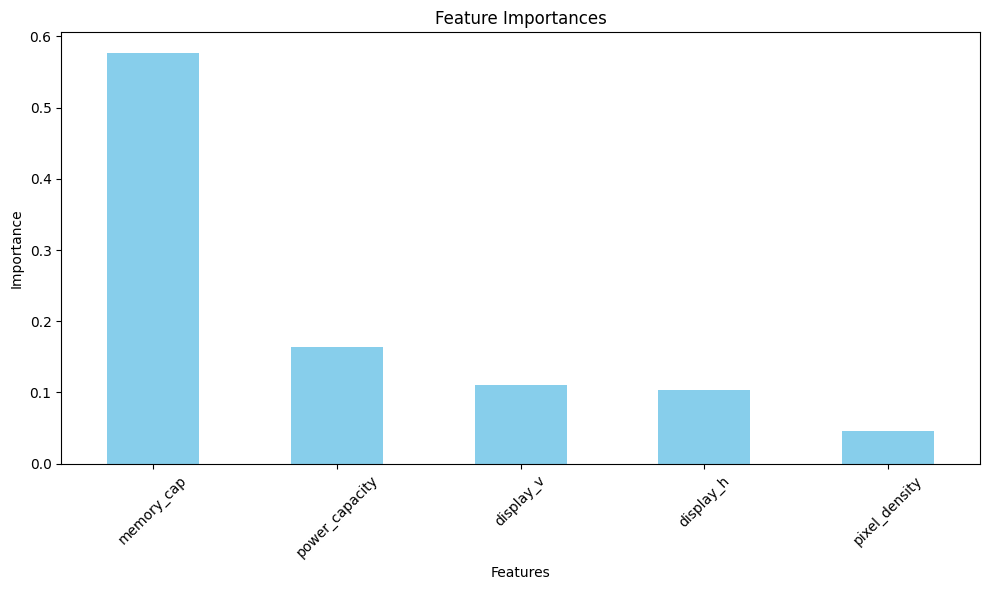

ExactExplainer explainer: 522it [00:30, 14.58it/s]                         


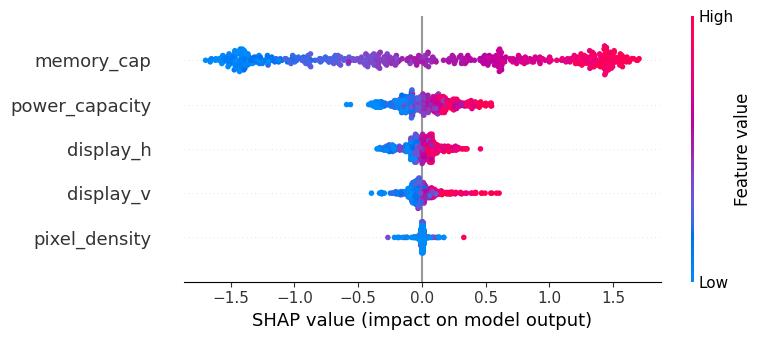

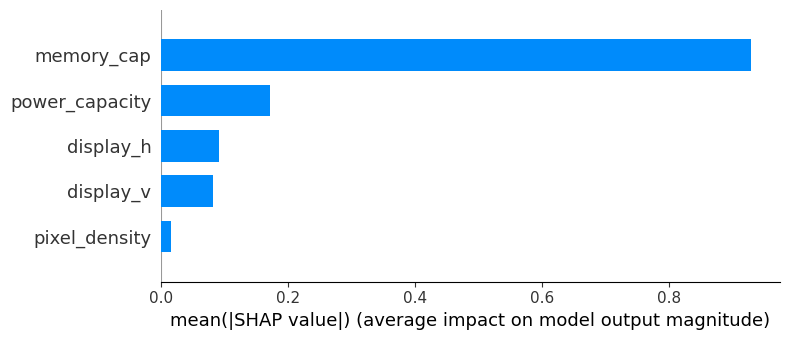

In [ ]:
# 繪製特徵重要性圖
plt.figure(figsize=(10, 6))
important_features.plot(kind='bar', color='skyblue')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import shap
# 分析：SHAP 值解釋
explainer = shap.Explainer(best_xgb_model.predict, X_test_selected)
shap_values = explainer(X_test_selected)
# 可視化 SHAP 值
shap.summary_plot(shap_values, X_test_selected)
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")





<ipython-input-9-c82a7fe232b1>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(df_copy[col].median(), inplace=True)


selected_features Index(['power_capacity', 'display_v', 'display_h', 'memory_cap',
       'pixel_density'],
      dtype='object')
Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1215, number of used features: 5
[LightGBM] [Info] Start training from score -1.369158
[LightGBM] [Info] Start training from score -1.425746
[LightGBM] [Info] Start training from score -1.359496
[LightGBM] [Info] Start training from score -1.392072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

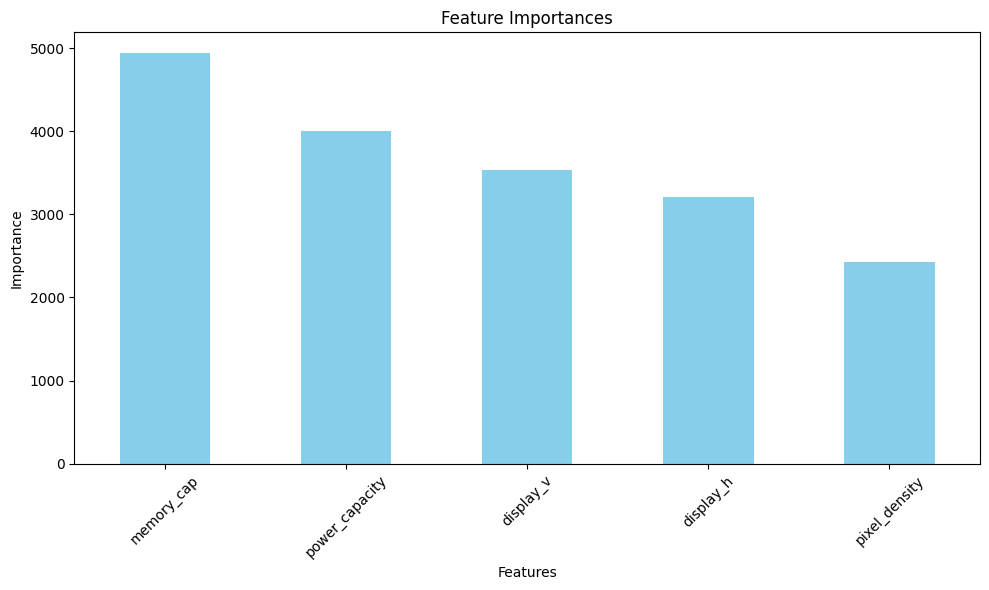

ExactExplainer explainer: 522it [04:58,  1.70it/s]


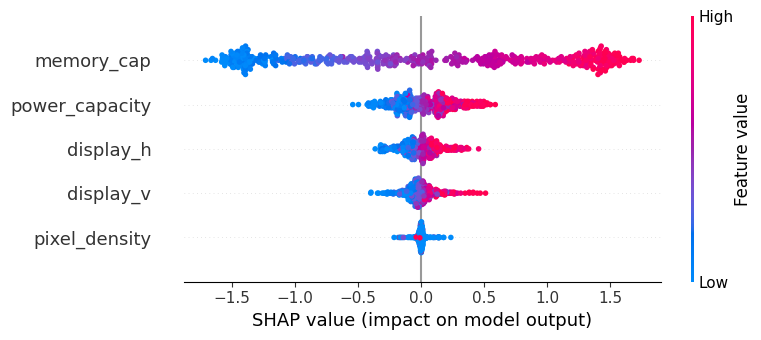

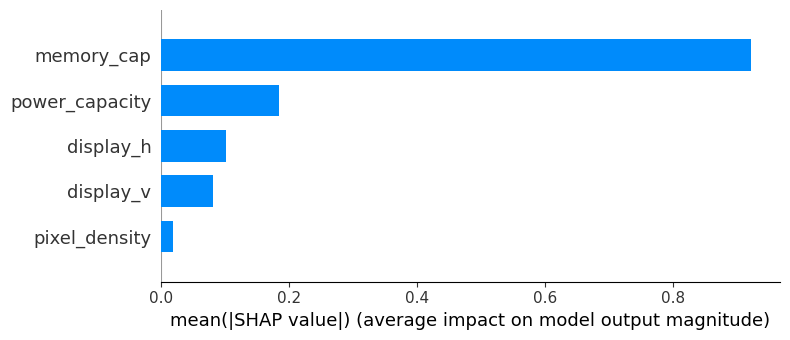

In [ ]:
#model 2: 改LightGBM 有lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve


#五種
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

df = pd.read_excel('dataset.xlsx')
df_copy = df.copy()
target_variable = 'market_segment'

##########################################################
#資料處理
#預處理1: 移除沒有目標變數的項目
df_copy.dropna(subset=[target_variable], inplace=True)
#預處理2: 用中位數補零
for col in df_copy.columns:
    if col != target_variable and pd.api.types.is_numeric_dtype(df_copy[col]):
        df_copy[col].fillna(df_copy[col].median(), inplace=True)
#預處理3: 1th-99th
for col in df_copy.select_dtypes(include=np.number):
    if col != target_variable:
        p1 = np.percentile(df_copy[col], 1)
        p99 = np.percentile(df_copy[col], 99)
        df_copy[col] = np.clip(df_copy[col], p1, p99)
#預處理4: 分訓練集&測試集7:3
train_df, test_df = train_test_split(df_copy, test_size=0.3, random_state=42)
#預處理5: 增加一個特徵：「像素密度」= ( display_v * display_h ) / (panel_height * panel_width)，再以Lasso回歸選擇特徵並分別以決策樹、隨機森林及類神經網路建模。決策樹的模型設定上，使用GridSearchCV，GridSearchCV param_grid = { 'n_estimators': [100, 200, 500], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', None] }用決策數建模後，分別對test_df進行預測，並計算評估指標(精確度、F1-Score)
for df in [train_df, test_df]:
    if {'display_v', 'display_h', 'panel_height', 'panel_width'}.issubset(df.columns):
        df['pixel_density'] = (df['display_v'] * df['display_h']) / (df['panel_height'] * df['panel_width']).replace(0,1e-6)
#預處理6: GridSearchCV，分離特徵和目標變數：將 market_segment 作為目標變數，其餘為特徵。
X_train = train_df.drop('market_segment', axis=1)
y_train = train_df['market_segment']
X_test = test_df.drop('market_segment', axis=1)
y_test = test_df['market_segment']
#預處理7(貌似無必要): 將目標變數 y_train 和 y_test（即 market_segment）從文字或類別型數據轉換成數字標籤，以便機器學習模型可以處理。
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.transform(y_test)


####################################################
lasso = Lasso(alpha=10)  # You might need to tune alpha
lasso.fit(X_train, y_train)
selected_features = X_train.columns[lasso.coef_ != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print("selected_features",selected_features)




# 3. 使用 GridSearchCV 調參並訓練 XGBoost 模型
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

'''
初始化了一個 XGBoost 分類器，即 XGBClassifier，並設置了一些特定參數
1.random_state=42 ->固定隨機種子以保證結果的可重現性。在每次執行中，隨機過程（如樣本選擇）會產生相同的結果。
2.use_label_encoder=False -> 從 XGBoost 1.3 版開始，為了與 Scikit-learn 接軌，XGBoost 支援直接處理數字標籤。設置為 False，表示不再使用內建的 LabelEncoder，而是依賴外部的編碼（如 Scikit-learn 的 LabelEncoder）。
3.eval_metric='logloss' ->設定評估指標為對數損失（logarithmic loss）。適用於多分類和二分類問題。該指標衡量預測的機率分佈與真實分佈的接近程度。
'''

###################################################

lgbm = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
#執行GridSearchCV
grid_search.fit(X_train_selected, y_train)

# 獲取grid_search最佳模型
best_lgbm_model = grid_search.best_estimator_

# 進行測試集評估
y_pred_test = best_lgbm_model.predict(X_test_selected)
y_pred_prob = best_lgbm_model.predict_proba(X_test_selected)  # 用於 AUC 計算

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')  # ROC AUC
pr_auc = average_precision_score(y_test, y_pred_prob, average='weighted')  # PR AUC

# 打印結果
print("LightGBM 版本:")
print("Best Parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC (ROC): {roc_auc:.4f}")
print(f"AUC (PR): {pr_auc:.4f}")
#分類報告
classification_rep = classification_report(y_test, y_pred_test)
print("Classification Report:\n", classification_rep)

# 特徵重要性分析
feature_importances = best_lgbm_model.feature_importances_
important_features = pd.Series(feature_importances, index=selected_features).sort_values(ascending=False)
print("Feature Importances:\n", important_features)
plt.figure(figsize=(10, 6))
important_features.plot(kind='bar', color='skyblue')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 分析：SHAP 值解釋
explainer = shap.Explainer(best_lgbm_model.predict, X_test_selected)
shap_values = explainer(X_test_selected)
# 可視化 SHAP 值
shap.summary_plot(shap_values, X_test_selected)
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")


In [ ]:
importance_gain = best_lgbm_model.booster_.feature_importance(importance_type='gain')
importances_gain = pd.Series(importance_gain, index=selected_features).sort_values(ascending=False)
print("Feature Importance (Gain):\n", importances_gain)

Feature Importance (Gain):
 memory_cap        6112.748342
power_capacity    1499.256080
display_v          818.951190
display_h          759.258003
pixel_density      197.275077
dtype: float64


selected_features Index(['power_capacity', 'display_v', 'display_h', 'memory_cap',
       'pixel_density'],
      dtype='object')
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-11-2c44b89728ee>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(df_copy[col].median(), inplace=True)
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


CatBoost 版本:
Best Parameters: {'depth': 7, 'iterations': 300, 'l2_leaf_reg': 4, 'learning_rate': 0.1}
Accuracy: 0.9002
Precision: 0.9001
Recall: 0.9002
F1-Score: 0.9001
AUC (ROC): 0.9884
AUC (PR): 0.9645
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       125
         1.0       0.90      0.89      0.90       136
         2.0       0.85      0.85      0.85       131
         3.0       0.90      0.92      0.91       129

    accuracy                           0.90       521
   macro avg       0.90      0.90      0.90       521
weighted avg       0.90      0.90      0.90       521

Feature Importances:
 memory_cap        58.248543
power_capacity    19.282575
display_h          9.698217
display_v          8.712117
pixel_density      4.058547
dtype: float64


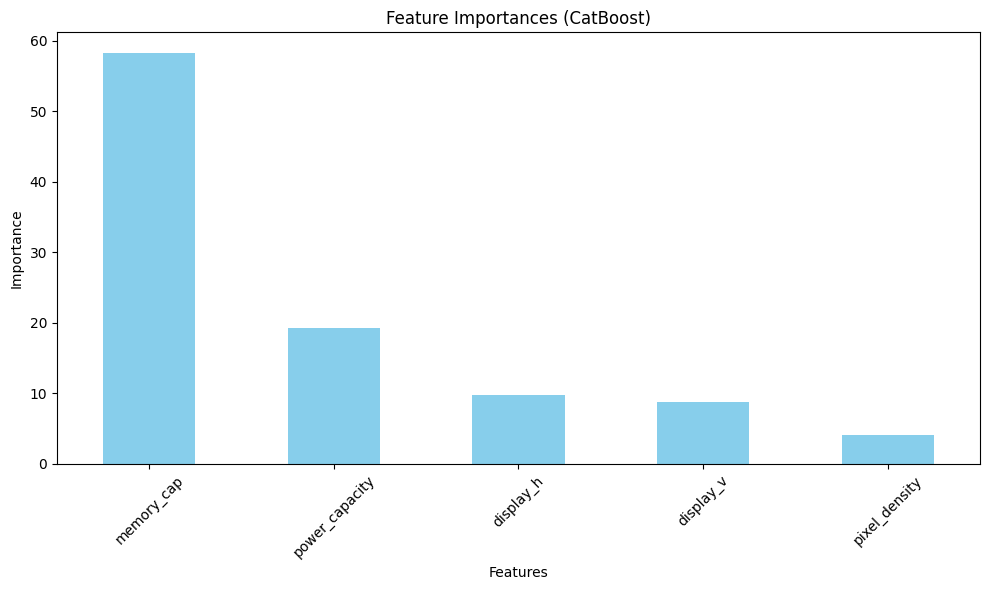

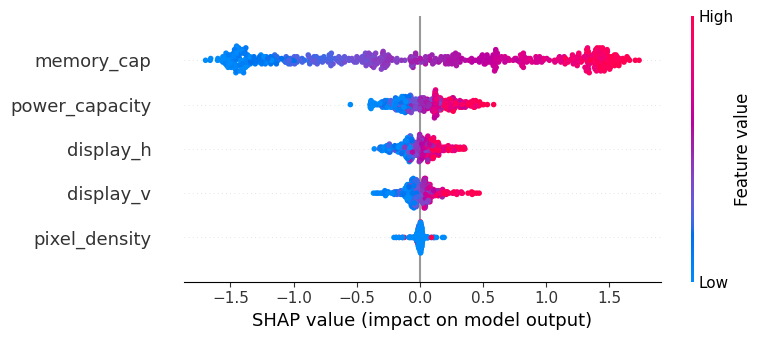

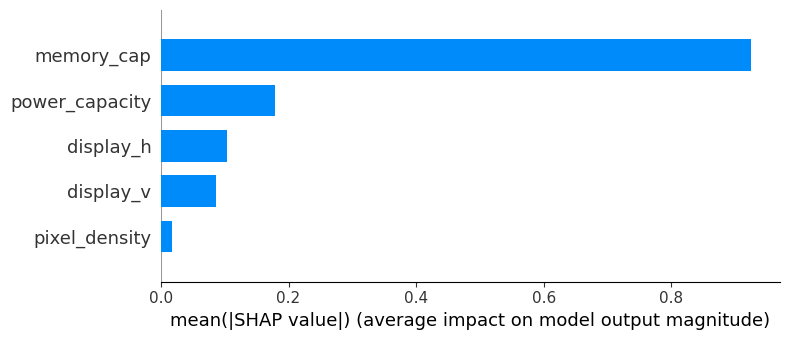

In [ ]:
#model 3: 改catboosting 有lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve


#五種
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

df = pd.read_excel('dataset.xlsx')
df_copy = df.copy()
target_variable = 'market_segment'

##########################################################
#資料處理
#預處理1: 移除沒有目標變數的項目
df_copy.dropna(subset=[target_variable], inplace=True)
#預處理2: 用中位數補零
for col in df_copy.columns:
    if col != target_variable and pd.api.types.is_numeric_dtype(df_copy[col]):
        df_copy[col].fillna(df_copy[col].median(), inplace=True)
#預處理3: 1th-99th
for col in df_copy.select_dtypes(include=np.number):
    if col != target_variable:
        p1 = np.percentile(df_copy[col], 1)
        p99 = np.percentile(df_copy[col], 99)
        df_copy[col] = np.clip(df_copy[col], p1, p99)
#預處理4: 分訓練集&測試集7:3
train_df, test_df = train_test_split(df_copy, test_size=0.3, random_state=42)
#預處理5: 增加一個特徵：「像素密度」= ( display_v * display_h ) / (panel_height * panel_width)，再以Lasso回歸選擇特徵並分別以決策樹、隨機森林及類神經網路建模。決策樹的模型設定上，使用GridSearchCV，GridSearchCV param_grid = { 'n_estimators': [100, 200, 500], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', None] }用決策數建模後，分別對test_df進行預測，並計算評估指標(精確度、F1-Score)
for df in [train_df, test_df]:
    if {'display_v', 'display_h', 'panel_height', 'panel_width'}.issubset(df.columns):
        df['pixel_density'] = (df['display_v'] * df['display_h']) / (df['panel_height'] * df['panel_width']).replace(0,1e-6)
#預處理6: GridSearchCV，分離特徵和目標變數：將 market_segment 作為目標變數，其餘為特徵。
X_train = train_df.drop('market_segment', axis=1)
y_train = train_df['market_segment']
X_test = test_df.drop('market_segment', axis=1)
y_test = test_df['market_segment']
#預處理7(貌似無必要): 將目標變數 y_train 和 y_test（即 market_segment）從文字或類別型數據轉換成數字標籤，以便機器學習模型可以處理。
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.transform(y_test)


####################################################
lasso = Lasso(alpha=10)  # You might need to tune alpha
lasso.fit(X_train, y_train)
selected_features = X_train.columns[lasso.coef_ != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print("selected_features",selected_features)




# 3. 使用 GridSearchCV 調參並訓練 XGBoost 模型
param_grid= {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}

'''
初始化了一個 XGBoost 分類器，即 XGBClassifier，並設置了一些特定參數
1.random_state=42 ->固定隨機種子以保證結果的可重現性。在每次執行中，隨機過程（如樣本選擇）會產生相同的結果。
2.use_label_encoder=False -> 從 XGBoost 1.3 版開始，為了與 Scikit-learn 接軌，XGBoost 支援直接處理數字標籤。設置為 False，表示不再使用內建的 LabelEncoder，而是依賴外部的編碼（如 Scikit-learn 的 LabelEncoder）。
3.eval_metric='logloss' ->設定評估指標為對數損失（logarithmic loss）。適用於多分類和二分類問題。該指標衡量預測的機率分佈與真實分佈的接近程度。
'''

###################################################

catboost = CatBoostClassifier(random_state=42, verbose=0)
grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_catboost_model = grid_search.best_estimator_
y_pred_test = best_catboost_model.predict(X_test_selected)
y_pred_prob = best_catboost_model.predict_proba(X_test_selected)

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')  # ROC AUC
pr_auc = average_precision_score(y_test, y_pred_prob, average='weighted')  # PR AUC

# 打印結果
print("CatBoost 版本:")
print("Best Parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC (ROC): {roc_auc:.4f}")
print(f"AUC (PR): {pr_auc:.4f}")
#分類報告
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# 特徵重要性分析
feature_importances = best_catboost_model.feature_importances_
important_features = pd.Series(feature_importances, index=selected_features).sort_values(ascending=False)
print("Feature Importances:\n", important_features)


plt.figure(figsize=(10, 6))
important_features.plot(kind='bar', color='skyblue')
plt.title('Feature Importances (CatBoost)')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 分析：SHAP 值解釋
explainer = shap.Explainer(best_catboost_model.predict, X_test_selected)
shap_values = explainer(X_test_selected)
# 可視化 SHAP 值
shap.summary_plot(shap_values, X_test_selected)
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")


<ipython-input-12-41689f16b1f1>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(df_copy[col].median(), inplace=True)


selected_features Index(['power_capacity', 'display_v', 'display_h', 'memory_cap',
       'pixel_density'],
      dtype='object')
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Gradient Boosting 版本:
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.8656
Precision: 0.8653
Recall: 0.8656
F1-Score: 0.8654
AUC (ROC): 0.9787
AUC (PR): 0.9369
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.91      0.92       125
         1.0       0.85      0.84      0.84       136
         2.0       0.81      0.80      0.81       131
         3.0       0.88      0.91      0.90       129

    accuracy                           0.87       521
   macro avg       0.87      0.87      0.87       521
weighted avg       0.87      0.87      0.87       521

Feature Importances:
 memory_cap        0.635101
power_capacity    0.163044
display_v         0.095

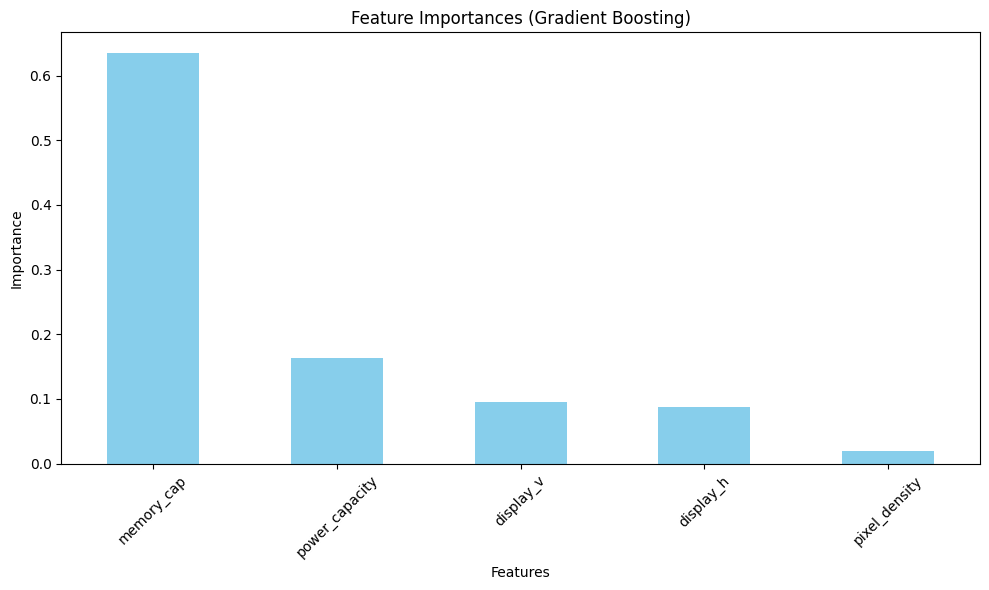

ExactExplainer explainer: 522it [00:29, 11.44it/s]


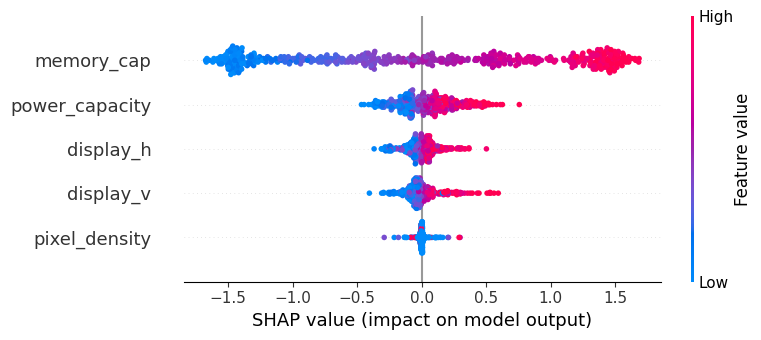

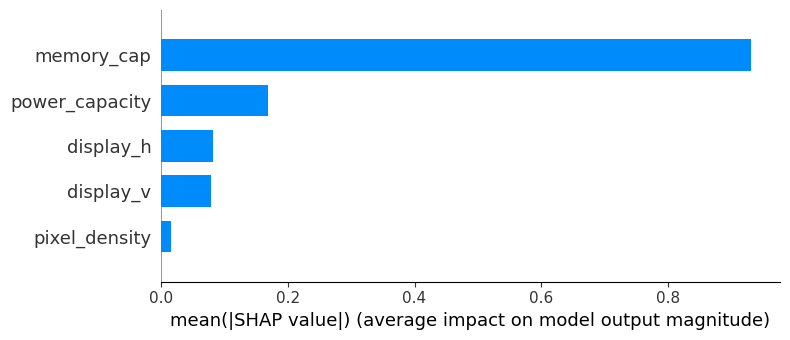

In [ ]:
#model 4: 改gradient boosting 有lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve


#五種
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

df = pd.read_excel('dataset.xlsx')
df_copy = df.copy()
target_variable = 'market_segment'

##########################################################
#資料處理
#預處理1: 移除沒有目標變數的項目
df_copy.dropna(subset=[target_variable], inplace=True)
#預處理2: 用中位數補零
for col in df_copy.columns:
    if col != target_variable and pd.api.types.is_numeric_dtype(df_copy[col]):
        df_copy[col].fillna(df_copy[col].median(), inplace=True)
#預處理3: 1th-99th
for col in df_copy.select_dtypes(include=np.number):
    if col != target_variable:
        p1 = np.percentile(df_copy[col], 1)
        p99 = np.percentile(df_copy[col], 99)
        df_copy[col] = np.clip(df_copy[col], p1, p99)
#預處理4: 分訓練集&測試集7:3
train_df, test_df = train_test_split(df_copy, test_size=0.3, random_state=42)
#預處理5: 增加一個特徵：「像素密度」= ( display_v * display_h ) / (panel_height * panel_width)，再以Lasso回歸選擇特徵並分別以決策樹、隨機森林及類神經網路建模。決策樹的模型設定上，使用GridSearchCV，GridSearchCV param_grid = { 'n_estimators': [100, 200, 500], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', None] }用決策數建模後，分別對test_df進行預測，並計算評估指標(精確度、F1-Score)
for df in [train_df, test_df]:
    if {'display_v', 'display_h', 'panel_height', 'panel_width'}.issubset(df.columns):
        df['pixel_density'] = (df['display_v'] * df['display_h']) / (df['panel_height'] * df['panel_width']).replace(0,1e-6)
#預處理6: GridSearchCV，分離特徵和目標變數：將 market_segment 作為目標變數，其餘為特徵。
X_train = train_df.drop('market_segment', axis=1)
y_train = train_df['market_segment']
X_test = test_df.drop('market_segment', axis=1)
y_test = test_df['market_segment']
#預處理7(貌似無必要): 將目標變數 y_train 和 y_test（即 market_segment）從文字或類別型數據轉換成數字標籤，以便機器學習模型可以處理。
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.transform(y_test)


####################################################
lasso = Lasso(alpha=10)  # You might need to tune alpha
lasso.fit(X_train, y_train)
selected_features = X_train.columns[lasso.coef_ != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print("selected_features",selected_features)


# 3. 使用 GridSearchCV 調參並訓練 XGBoost 模型
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

'''
初始化了一個 XGBoost 分類器，即 XGBClassifier，並設置了一些特定參數
1.random_state=42 ->固定隨機種子以保證結果的可重現性。在每次執行中，隨機過程（如樣本選擇）會產生相同的結果。
2.use_label_encoder=False -> 從 XGBoost 1.3 版開始，為了與 Scikit-learn 接軌，XGBoost 支援直接處理數字標籤。設置為 False，表示不再使用內建的 LabelEncoder，而是依賴外部的編碼（如 Scikit-learn 的 LabelEncoder）。
3.eval_metric='logloss' ->設定評估指標為對數損失（logarithmic loss）。適用於多分類和二分類問題。該指標衡量預測的機率分佈與真實分佈的接近程度。
'''

###################################################

gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_gb_model  = grid_search.best_estimator_
y_pred_test = best_gb_model.predict(X_test_selected)
y_pred_prob = best_gb_model.predict_proba(X_test_selected)

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')  # ROC AUC
pr_auc = average_precision_score(y_test, y_pred_prob, average='weighted')  # PR AUC

# 打印結果
print("Gradient Boosting 版本:")
print("Best Parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC (ROC): {roc_auc:.4f}")
print(f"AUC (PR): {pr_auc:.4f}")
#分類報告
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# 特徵重要性分析
feature_importances = best_gb_model.feature_importances_
important_features = pd.Series(feature_importances, index=selected_features).sort_values(ascending=False)
print("Feature Importances:\n", important_features)


plt.figure(figsize=(10, 6))
important_features.plot(kind='bar', color='skyblue')
plt.title('Feature Importances (Gradient Boosting)')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 分析：SHAP 值解釋
explainer = shap.Explainer(best_gb_model.predict, X_test_selected)
shap_values = explainer(X_test_selected)
# 可視化 SHAP 值
shap.summary_plot(shap_values, X_test_selected)
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")
